В ноутубке производится подбор параметров для модели Neural Prophet и запускается предскзание на каждый терминал

requirements:
* pandas
* numpy
* neuralprophet
* sklearn
* math

In [1]:
import pandas as pd
import numpy as np
from neuralprophet import NeuralProphet, set_log_level, set_random_seed

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from math import sqrt

## Функции

In [2]:
def calc_metrics(df_metric):
    """
    Рассчет метрик
    """
    df_metric = df_metric.copy()
    calc_mean = df_metric['ytrue'].mean()
    mae = mean_absolute_error(df_metric['ytrue'], df_metric['ypred'])
    mape = mean_absolute_percentage_error(df_metric[df_metric['ytrue']!=0]['ytrue'], 
                                          df_metric[df_metric['ytrue']!=0]['ypred'])
    rmse = sqrt(mean_squared_error(df_metric['ytrue'], df_metric['ypred']))

    print(calc_mean)
    print('MAE = ', mae, ' %mean = ', mae / calc_mean * 100)
    print('MAPE = ', mape * 100)
    print('RMSE = ', rmse,  ' %mean = ', rmse / calc_mean * 100)

## Выгрузка данных

In [3]:
incomes = pd.read_excel('../data/raw/terminal_data_hackathon v4.xlsx', sheet_name='Incomes')
print(incomes.shape)
incomes.head(2)

(1630, 93)


,TID,остаток на 31.08.2022 (входящий),2022-09-01 00:00:00,2022-09-02 00:00:00,2022-09-03 00:00:00,2022-09-04 00:00:00,2022-09-05 00:00:00,2022-09-06 00:00:00,2022-09-07 00:00:00,2022-09-08 00:00:00,...,2022-11-21 00:00:00,2022-11-22 00:00:00,2022-11-23 00:00:00,2022-11-24 00:00:00,2022-11-25 00:00:00,2022-11-26 00:00:00,2022-11-27 00:00:00,2022-11-28 00:00:00,2022-11-29 00:00:00,2022-11-30 00:00:00
0,406136,160000,90000,105000,99000,107000,110000,60000,75000,89000,...,91000,78000,0,165000,0,189000,106000,94000,75000,74000
1,406139,387000,103000,206000,168000,124000,78000,165000,164000,174000,...,164000,153000,151000,157000,206000,182000,123000,138000,112000,179000


## Смотрим данные

In [4]:
incomes[incomes['остаток на 31.08.2022 (входящий)'] > 1_000_000]['остаток на 31.08.2022 (входящий)']

245     1132000
560     1053000
574     1517000
814     1010000
1141    6019000
1275    1098000
1277    1042000
1339    2999000
1441    1038000
1455    1185000
1489    2347000
Name: остаток на 31.08.2022 (входящий), dtype: int64

In [5]:
incomes_T = incomes.set_index('TID').drop(['остаток на 31.08.2022 (входящий)'], axis=1).T
incomes_T.index = pd.to_datetime(incomes_T.index)
incomes_T['sum_all'] = incomes_T.sum(axis=1)

<Axes: >

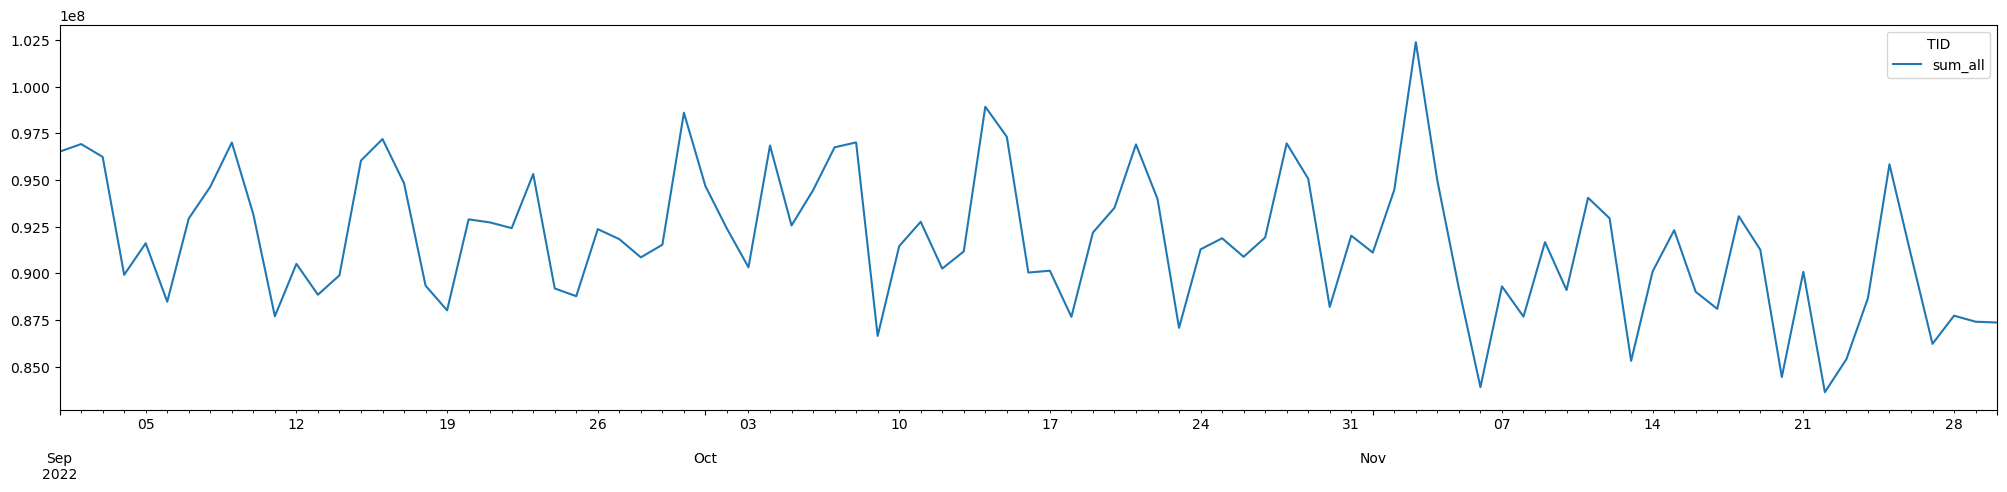

In [6]:
incomes_T[['sum_all']].plot(figsize=(25,5))

In [7]:
incomes_T.head(2)

TID,406136,406139,406145,406148,406180,406190,406196,406504,406509,406536,...,699540,699560,699572,699577,699578,699579,699629,699641,699664,sum_all
2022-09-01,90000,103000,143000,50000,96000,219000,115000,382000,128000,63000,...,80000,110000,124000,0,0,49000,63000,63000,0,96520000
2022-09-02,105000,206000,136000,73000,82000,236000,123000,317000,126000,65000,...,102000,57000,0,25000,0,68000,63000,0,0,96929000


## NeuralProphet - запуск на один терминал

In [8]:
set_random_seed(42)
set_log_level("CRITICAL")

model = NeuralProphet(
    n_changepoints=2,
    changepoints_range = 0.75,
    epochs = 100,
    weekly_seasonality=True,
    daily_seasonality=False,yearly_seasonality=False,
)

terminal = 406136
end_date = '2022-10-18'
df_train = incomes_T[incomes_T.index<end_date][[terminal]]\
          .reset_index()\
          .rename(columns={'index':'ds', terminal:'y'})
model.fit(df_train);

Missing logger folder: /Users/mariastepanova/MariaStepanova/Хакатон/ЛЦТ 2023/gazprom-terminal-optimizer/notebooks/lightning_logs


Finding best initial lr:   0%|          | 0/204 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [9]:
future_dates = model.make_future_dataframe(df_train, n_historic_predictions=True, periods=14)
prediction = model.predict(future_dates)
prediction.head(1)

Predicting: 3it [00:00, ?it/s]

,ds,y,yhat1,trend,season_weekly
0,2022-09-01,90000,60862.082031,93045.351562,-32183.269531


In [10]:
#Добавление таргета за первые два месяца для отрисовки
prediction['ypred'] = prediction['yhat1'].copy()
prediction.loc[prediction['ds']<end_date, 'yhat1']= prediction.loc[prediction['ds']<end_date, 'y']

In [11]:
model.plot(prediction)

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': 'yhat1',
              'type': 'scatter',
              'uid': '49cf662e-31fa-4262-8fcb-c8e67f65b6d5',
              'x': array([datetime.datetime(2022, 9, 1, 0, 0),
                          datetime.datetime(2022, 9, 2, 0, 0),
                          datetime.datetime(2022, 9, 3, 0, 0),
                          datetime.datetime(2022, 9, 4, 0, 0),
                          datetime.datetime(2022, 9, 5, 0, 0),
                          datetime.datetime(2022, 9, 6, 0, 0),
                          datetime.datetime(2022, 9, 7, 0, 0),
                          datetime.datetime(2022, 9, 8, 0, 0),
                          datetime.datetime(2022, 9, 9, 0, 0),
                          datetime.datetime(2022, 9, 10, 0, 0),
                          datetime.datetime(2022, 9, 11, 0, 0),
                       

In [12]:
for_metrics = incomes_T[incomes_T.index>=end_date][[terminal]]\
                                 .rename(columns={terminal: 'ytrue'})\
    .merge(prediction[prediction['ds']>=end_date][['ds', 'ypred']]\
            .set_index('ds')
          , left_index=True, right_index=True)
for_metrics['residuals'] = for_metrics['ytrue'] - for_metrics['ypred']
for_metrics.head(2)

,ytrue,ypred,residuals
2022-10-18,115000,93411.09375,21588.90625
2022-10-19,95000,97789.21875,-2789.21875


In [13]:
model.plot_components(prediction, components=["trend"])

FigureWidgetResampler({
    'data': [{'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',
              'name': 'Trend',
              'showlegend': False,
              'type': 'scatter',
              'uid': 'c2dcf266-662b-4195-bcb4-ab80f52cd23a',
              'x': array([datetime.datetime(2022, 9, 1, 0, 0),
                          datetime.datetime(2022, 9, 2, 0, 0),
                          datetime.datetime(2022, 9, 3, 0, 0),
                          datetime.datetime(2022, 9, 4, 0, 0),
                          datetime.datetime(2022, 9, 5, 0, 0),
                          datetime.datetime(2022, 9, 6, 0, 0),
                          datetime.datetime(2022, 9, 7, 0, 0),
                          datetime.datetime(2022, 9, 8, 0, 0),
                          datetime.datetime(2022, 9, 9, 0, 0),
                          datetime.datetime(2022, 9, 10, 0, 0),
                          datetime.datetime(2022, 9, 11, 0, 0),
                          datetime

In [14]:
#есть два терминала, у которых на последние 2 недели октября одни нули. Им n_changepoints будет поставлено 2
tt = incomes_T[(incomes_T.index>'2022-10-18')&(incomes_T.index<'2022-11-01')].sum()
tt[tt==0].index.tolist()

[629806, 634736]

In [15]:
calc_metrics(for_metrics)

94571.42857142857
MAE =  14936.53515625  %mean =  15.793919349509064
MAPE =  16.015361233992657
RMSE =  17425.96243243518  %mean =  18.426244263904266


## Прогон по всем вариантам гиперпараметра n_changepoints

*Обучение на 1.5мес, предсказание на 14 дней, чтобы найти наилучшее количество n_changepoints*

In [ ]:
%%time
end_date = '2022-10-18'
pd.DataFrame({'terminal':[], 'n_changepoints':[], 'mape':[]})\
    .to_csv('../data/processed/n_changepoints_select.csv', mode='w', header=True, index=False)

list_of_terminals = set(incomes_T.columns.tolist()).difference(set([629806, 634736]))

for terminal in list_of_terminals:

    l_terminal, l_n_changepoints, l_mape = [], [], []
    d_res = {'terminal':[], 'n_changepoints':[], 'mape':[]}
    
    for i in range(0,6):
        
        model = NeuralProphet(
                n_changepoints=i, 
                changepoints_range = 0.75,
                epochs = 100,
                weekly_seasonality=True,
                daily_seasonality=False,yearly_seasonality=False,);
        set_random_seed(42)
        set_log_level("CRITICAL")

        df_train = incomes_T[incomes_T.index<end_date][[terminal]]\
                  .reset_index()\
                  .rename(columns={'index':'ds', terminal:'y'})
        model.fit(df_train);

        future_dates = model.make_future_dataframe(df_train, n_historic_predictions=False, periods=14)
        prediction = model.predict(future_dates)

        prediction['ypred'] = prediction['yhat1'].copy()
        prediction.loc[prediction['ds']<end_date, 'yhat1']= prediction.loc[prediction['ds']<end_date, 'y']

        #для рассчета метрики
        for_metrics = incomes_T[incomes_T.index>=end_date][[terminal]]\
                                     .rename(columns={terminal: 'ytrue'})\
            .merge(prediction[prediction['ds']>=end_date][['ds', 'ypred']]\
                    .set_index('ds')
                  , left_index=True, right_index=True)
        mape = mean_absolute_percentage_error(for_metrics[for_metrics['ytrue']!=0]['ytrue'], 
                                              for_metrics[for_metrics['ytrue']!=0]['ypred'])
        
        l_terminal.append(terminal)
        l_n_changepoints.append(i)
        l_mape.append(mape)

    d_res['terminal'].extend(l_terminal)
    d_res['n_changepoints'].extend(l_n_changepoints)
    d_res['mape'].extend(l_mape)
    
    pd.DataFrame(d_res).to_csv('../data/processed/n_changepoints_select.csv', mode='a'
                               , header=False, index=False)
    

In [16]:
df_res = pd.read_csv('../data/processed/n_changepoints_select.csv', header=0) 
df_res = df_res[df_res['terminal']!='sum_all'].reset_index(drop=True)
df_res['terminal'] = df_res['terminal'].astype(int)
df_res.head()

,terminal,n_changepoints,mape
0,406136,0,0.165501
1,406136,1,0.178011
2,406136,2,0.160154
3,406136,3,0.177978
4,406136,4,0.160214


In [17]:
#Выбираем n_changepoints с минимальным mape
min_mape = df_res.groupby(by='terminal', as_index=False)[['mape']].min()
df_res = df_res.merge(min_mape, how='left', on='terminal')
df_res = df_res[df_res['mape_x'] == df_res['mape_y']]
df_res.head()

,terminal,n_changepoints,mape_x,mape_y
2,406136,2,0.160154,0.160154
7,406139,1,0.229066,0.229066
15,406145,3,0.151961,0.151961
18,406148,0,0.211151,0.211151
24,406180,0,0.233601,0.233601


In [18]:
#терминалы, на которые не получится посчитать mape, т.к в конце октября они были неактивны
bad_terminals = pd.DataFrame({'terminal': [629806, 634736], 'n_changepoints': [2,2], 
              'mape_x':[np.nan, np.nan], 'mape_y':[np.nan, np.nan],})
bad_terminals.head()

,terminal,n_changepoints,mape_x,mape_y
0,629806,2,NaN,NaN
1,634736,2,NaN,NaN


In [19]:
df_res = pd.concat([df_res, bad_terminals]).reset_index(drop=True)

In [20]:
print(f'Ошибка на валидационной выборке (последние 14 дней октября) ', df_res['mape_x'].mean()*100 , '%')

Ошибка на валидационной выборке (последние 14 дней октября)  23.891195393482644 %


In [21]:
d_best_changepoints = df_res[['terminal', 'n_changepoints']].set_index('terminal').T.to_dict()

## NeuralProphet Предсказание на все терминалы

*Обучение на 2х месяцах и предсказание на 3ий*

In [ ]:
%%time
end_date = '2022-11-01'
pd.DataFrame({'terminal':[], 'ds':[], 'yhat1':[]})\
    .to_csv('../data/processed/predictions.csv', mode='w', header=True, index=False)

for terminal, d_changepoints in d_best_changepoints.items():

    l_terminal, l_n_changepoints, l_mape = [], [], []
    d_res = {'terminal':[], 'n_changepoints':[], 'mape':[]}
        
    model = NeuralProphet(
            n_changepoints=int(d_changepoints['n_changepoints']), 
            changepoints_range = 0.75,
            epochs = 100,
            weekly_seasonality=True,
            daily_seasonality=False,yearly_seasonality=False,);
    set_random_seed(42)
    set_log_level("CRITICAL")

    df_train = incomes_T[incomes_T.index<end_date][[terminal]]\
              .reset_index()\
              .rename(columns={'index':'ds', terminal:'y'})
    model.fit(df_train);

    future_dates = model.make_future_dataframe(df_train, n_historic_predictions=False, periods=30)
    prediction = model.predict(future_dates)
    prediction['terminal'] = terminal
    
    prediction[['terminal', 'ds', 'yhat1']].to_csv('../data/processed/predictions.csv', mode='a'
                               , header=False, index=False)
    

In [22]:
df_predictions = pd.read_csv('../data/processed/predictions.csv', header=0) 
df_predictions.loc[df_predictions['yhat1']<0, 'yhat1'] = 0
df_predictions.to_csv('../data/processed/predictions_correct.csv', header=True, index=False)
df_predictions.head()

,terminal,ds,yhat1
0,406136,2022-11-01,92996.054688
1,406136,2022-11-02,93618.015625
2,406136,2022-11-03,69367.390625
3,406136,2022-11-04,106759.367188
4,406136,2022-11-05,103091.031250


In [23]:
df_predictions['terminal'].drop_duplicates().shape

(1630,)

In [24]:
#Как можно отдавать результат
pd.pivot_table(df_predictions, index='terminal', columns='ds', values='yhat1').head()

ds,2022-11-01,2022-11-02,2022-11-03,2022-11-04,2022-11-05,2022-11-06,2022-11-07,2022-11-08,2022-11-09,2022-11-10,...,2022-11-21,2022-11-22,2022-11-23,2022-11-24,2022-11-25,2022-11-26,2022-11-27,2022-11-28,2022-11-29,2022-11-30
terminal,,,,,,,,,,,,,,,,,,,,,
406136,92996.054688,93618.015625,69367.390625,106759.367188,103091.031250,115568.171875,76665.265625,92665.390625,93287.335938,69036.718750,...,76003.906250,92004.046875,92625.992188,68375.367188,105767.343750,102099.007812,114576.156250,75673.242188,91673.367188,92295.312500
406139,101205.078125,193767.031250,135787.140625,174668.265625,159080.687500,135718.093750,136037.453125,98160.750000,190722.703125,132742.796875,...,129948.781250,92072.085938,184634.015625,126654.132812,165535.265625,149947.687500,126585.070312,126904.445312,89027.750000,181589.671875
406145,155808.500000,128303.257812,133807.468750,99783.242188,113430.828125,130733.492188,98310.289062,152015.750000,124510.492188,130014.695312,...,90724.757812,144430.218750,116924.968750,122429.164062,88404.953125,102052.539062,119355.187500,86931.992188,140637.453125,113132.203125
406148,79163.781250,68157.328125,63485.785156,64836.824219,78779.570312,58951.886719,57120.714844,79266.757812,68260.296875,63588.750000,...,57326.656250,79472.695312,68466.242188,63794.687500,65145.730469,79088.476562,59260.789062,57429.625000,79575.664062,68569.210938
406180,84681.898438,71381.546875,101369.656250,93711.757812,77114.031250,78070.078125,70443.382812,85998.578125,72698.226562,102686.335938,...,73076.734375,88631.937500,75331.585938,105319.687500,97661.804688,81064.078125,82020.117188,74393.414062,89948.617188,76648.265625


In [25]:
df_true = pd.melt(incomes_T.reset_index(), id_vars=['index'], 
        value_vars=incomes_T.columns.tolist())\
        .rename(columns={'index': 'ds', 'TID': 'terminal', 'value': 'ytrue'})
df_true['ds'] = df_true['ds'].astype(str)
df_true.head()

,ds,terminal,ytrue
0,2022-09-01,406136,90000
1,2022-09-02,406136,105000
2,2022-09-03,406136,99000
3,2022-09-04,406136,107000
4,2022-09-05,406136,110000


In [26]:
for_metrics = df_predictions.rename(columns={'yhat1': 'ypred'})\
            .merge(df_true, how='left', on = ['terminal', 'ds'])
for_metrics['residuals'] = for_metrics['ytrue'] - for_metrics['ypred']
for_metrics.head(2)

,terminal,ds,ypred,ytrue,residuals
0,406136,2022-11-01,92996.054688,73000,-19996.054688
1,406136,2022-11-02,93618.015625,84000,-9618.015625


In [27]:
calc_metrics(for_metrics)

55166.99386503067
MAE =  14475.999472780793  %mean =  26.24032679430963
MAPE =  25.970726788927756
RMSE =  28215.170101961878  %mean =  51.14502010204139
